**Engy-5050** Reactor Physics, UMass Lowell, Chem. Eng. Nuclear Program Spring 2022; Prof. V. F. de Almeida

# 1-D Point Source Neutron Transport
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\uvar}{\boldsymbol{u}}
  \newcommand{\fvar}{\boldsymbol{f}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Power}{\mathcal{P}}
$

**Student(s):** Anthony Bowers, Andrew Hamel <br>
**Course:** Engy-5050 Reactor Physics  <br>


UMass Lowell, Dept. of Chemical Engineering, Nuclear Energy Program 
<br>
**7March2022**

---
## Table of Contents<a id="toc"></a>
* [Introduction](#intro)
* [Problem Statement](#problem)
* [Objectives](#obj)
* [FEM Approach](#app)
 + [Analytical Solution](#analyticalsol)
 + [Weak Form of Problem Statement](#weakform)
 + [MOOSE Kernels](#kernels)
 + [Setup](#setup)
    - [One-Group Energy](#onegroupenergy)
    - [Two-Group Energy](#twogroupenergy)
* [FDM Approach](#appFDM)
 + [Discretization](#setupFDM)
    - [One-Group Energy](#onegroupenergyFDM)
    - [Two-Group Energy](#twogroupenergyFDM)
    - [Issue occurs when coupling flux at boundary to albedo condition](#issue)
* [Results and Analysis](#ranalysis)
* [Conclusions](#conclusions)
* [References](#refs)
---

## [Introduction](#toc)<a id="intro"></a>

## [Problem Statement](#toc)<a id="problem"></a>

This investigation looks to determine how Finite Element Method (FEM) computation of the neutron diffusion equation compare to that of the Finite Difference Method (FDM) computation given standard assumptions about the definition of the diffusion coefficient in homogenous mediums far from and close to voids. Defining diffusion coefficients for neutron transport is an active field of research and includes approximations such as isotropic scattering, linear in angle, nonlocal weighting of nearby average transport properties, Monte Carlo study and experiment.



### [Strong Form of Problem Statement BARE REACTOR](#toc)<a id="dbcstrong"></a>

 Find $\Phi_1:[a,b]\subset \mathbb{R} \rightarrow\mathbb{R}$ and $\Phi_2:[a,b]\subset\mathbb{R}\rightarrow\mathbb{R}$ for $D_1 > 0$ and $D_2 > 0$ such that:

\begin{align*}
 0= -div_{x}(-D_1\, \nabla_{x}\Phi_1)- \Sigma_{1,a} \Phi_1(x)+ S(\Phi_1, \Phi_2) + \chi(E_{1}) \frac{v}{k}\Sigma_{1,f}\Phi_1(x)  \quad \forall \quad x\in [a,b], \\
-D_1 \nabla \Phi_1(a) &= 0, \\
 -D_1 \nabla \Phi_1(b) &= ( \frac{1}{2} \Phi_1).
\end{align*}

and

\begin{align*}
  0= -div_{x}(-D_2\,\nabla_{x}\Phi_2) -\Sigma_{2,a} \Phi_2(x) - S(\Phi_1, \Phi_2) + \chi(E_{2}) \frac{v}{k}\Sigma_{2,f}\Phi_2(x)  \quad \forall \quad x\in [a,b], \\
 -D_2 \nabla \Phi_2(a) &= 0, \\
 -D_2 \nabla \Phi_2(b) &= ( \frac{1}{2} \Phi_2).
\end{align*}

The *diffusion flux* associated to the quantity $\Phi_i, \, \ i=1,2$ is denoted $q_i := -D_i\,\Phi_i'$, and it is often of interest as a derived quantity of the neutron spatial transport theory. 

## [Source Coupling](#toc)<a id="sourcecoupling"></a>

Consider the following source coupling:

\begin{align*}
 S(\Phi_1, \Phi_2) = S_1 - h_1\,\bigl(\Phi_1-\Phi_1^*\bigr) - \Bigl( S_2 - h_2\, \bigl(\Phi_2 - \Phi_2^*\bigr) \Bigr)
\end{align*}

where $S_i$ is a fixed source (sink) for each Neutron group, $h_i$ is a transfer coefficient, and $\Phi_i^*$ is a saturation value.

Moreover, for this particular problem:

\begin{align*}
 S_1=0 \\
 S_2=0 \\
 \Phi_2=0 \\
 \Phi_1^*=0 \\
 \Phi_2^*=0 \\
 h_1=\Sigma_{s,1 \rightarrow 2} \\
 h_2=0
\end{align*}

Enstating these values reduces the source coupling to 
\begin{align*}
 S(\Phi_1, \Phi_2) = -\Sigma_{s,1 \rightarrow 2} \Phi_1 
\end{align*}

Where the conceptual reads this means that group one neutrons looses neutrons due to the downscattering into group two. Conversely this means group two has a source term. Moreover, if upscattering was to be taken into account $h_2 = \Sigma_{s,2 \rightarrow 1}$ and $\Phi_2$ would exist for a combined source term of, 

\begin{align*}
 S(\Phi_1, \Phi_2) = -\Sigma_{s,1 \rightarrow 2} \Phi_1 + \Sigma_{s,2 \rightarrow 1} \Phi_2
\end{align*}

## [FEM Approach](#toc)<a id="app"></a>

### [Weak Form of Problem Statement](#toc)<a id="weakform"></a> 

The Galerkin weak formulation of the strong form is as follows. Find $\Phi_1 \in H^1\!\bigl([a,b]\bigr)$ and $\Phi_2 \in H^1\!\bigl([a,b]\bigr)$
so that 

\begin{align*}
 \int\limits_a^b \Sigma_{1,a}  \Phi_1(x)\, w(x)\,dx + \int\limits_a^b D\, \Phi_1'(x)\,w'(x)\,dx - \int\limits_a^b S(\Phi_1, \Phi_2)\,w(x)\,dx &= 0 \quad \forall \quad w \in H^1_0\!\bigl([a,b]\bigr), \text{and}
 \\
  \int\limits_a^b \Sigma_{2,a}  \Phi_2(x)\, w(x)\,dx + \int\limits_a^b D\, \Phi_2'(x)\,w'(x)\,dx + \int\limits_a^b S(\Phi_1, \Phi_2)\,w(x)\,dx &= 0 \quad \forall \quad w \in H^1_0\!\bigl([a,b]\bigr),
\end{align*}

where $H^1\!\bigl([a,b]\bigr) := \bigl\{ \Phi:[a,b]\subset\mathbb{R}\rightarrow\mathbb{R} \mid \int_a^b \Phi'^2\,dx < \infty\bigr\}$ and $H^1_0\!\bigl([a,b]\bigr) := \bigl\{ w \mid w \in H^1(a,b), w(a) = 0, w(b) =0 \bigr\}$. Both function sets as just defined are Hilbert spaces. The function $w$ is called a test function. Because $w$, $\Phi_1$, $\Phi_2$ are sought in very similar sets of functions, this weak form is called Galerkin's weak form.

The new form of the source term is the key term to be computed here. Since the MOOSE framework performs the integration, and provides the implementation of the test function, we need to provide the integrand of the integral, that is, the kernel. Therefore the kernel needed is an expansion of what has been covered so far in the course:

 1. $\pm S(\Phi_1, \Phi_2)\,w(x)$.
 
The kernels are to be evaluated at quadrature points provided by the MOOSE framework.
1. Multiply NDE by a test function $\phi$.
2. Integrate over spatial and angular domain.
3. Use divergence theorem to set the boundary condition across the domain surface.

The weak form becomes:

\begin{align*}
    ( \nabla \phi, D_1 \nabla \Phi_1  )\ - < \phi, D_1 \nabla \Phi_1 \cdot \bar{n_b} > +\ (\phi , \lambda \Phi_1) = 0 \ \ \ (G1)\\\\
 \lambda = \chi(E_{1}) \frac{v}{k}\Sigma_{1,f} - S(\Phi_1, \Phi_2) -\Sigma_{a,1} ;\\ S(\Phi_1, \Phi_2) = -\Sigma_{s,1 \rightarrow 2} \Phi_1  \\ \\
      ( \nabla \phi, D_2 \nabla \Phi_2  )\ - < \phi, D_2 \nabla \Phi_2 \cdot \bar{n_b} > +\ (\phi , \lambda \Phi_2)  (\phi,S(\Phi_1, \Phi_2)) = 0 \ \ \ (G2)\\\\
      \lambda =\chi(E_{2}) \frac{v}{k}\Sigma_{2,f} -\Sigma_{a,2}\\
      S(\Phi_1, \Phi_2) = -\Sigma_{s,1 \rightarrow 2} \Phi_1 \\
\end{align*}

#### Neumann B.C Weak Form:
This weak form contains the volume and surface integral as written with parenthesis and brackets respectively. 

Then boundary conition at the center, $a$, is implemented and descritized as such: 
\begin{align*}
\\
 -D_1\nabla \Phi_1(a) &= 0 \\
  -D_2 \nabla \Phi_2(a) &= 0 \\\\
\end{align*}

\begin{align*}
     \phi (-D_1 \nabla \Phi_1(b) \cdot \bar{n_b}) =0 \\
     \phi (-D_2 \nabla \Phi_2(b) \cdot \bar{n_b}) = 0
\end{align*}
#### Vacuum B.C  Weak Form:
Then the boundary conditions for the partial currents at the surface, $b$, given as $\Gamma^{\pm}$ must be solved for:

\begin{align*}
    J_n^{+} = J^{out}({R_S}) =  J^{out}({b}) = J^{+}
\end{align*}

\begin{align*}
    J_n^{-} = J^{in}({R_S}) = 0
\end{align*}

Here we will use the Robin Vacuum boundary condition, at position $b$, such that the reflectivity at the boundary is 0 as:


\begin{align*}
    J^{\pm}_{E,n} = \frac{1}{4} \Phi \pm \frac{1}{2} D \nabla \Phi \cdot \bar{n_b} \\
   J^{-}_{E,n} = 0 = \frac{\Phi}{4} - \frac{J_{E,n}}{2}  = \frac{\Phi}{4} - \frac{-D \nabla \Phi}{2}\\
    \frac{\Phi}{4} = \frac{-D \nabla \Phi}{2}
\end{align*}


Solving for the weak form boundary condition and multiplying our test function $\phi$:

\begin{align*}
     - <\phi,D_1 \nabla \Phi_1(b) \cdot \bar{n_b}> = \phi( \frac{1}{2}  \Phi_1) \\
    - <\phi,D_2 \nabla \Phi_2(b) \cdot \bar{n_b}> = \phi( \frac{1}{2}  \Phi_2)
\end{align*}
#### Albedo B.C (Partially Reflective)  Weak Form:

Then the boundary conditions for the partial currents at the surface, $b$, given as $\Gamma^{\pm}$ must be solved for:

\begin{align*}
  \frac{ J^{+}_{E,n}}{J^{-}_{E,n}} = \alpha = \frac{ J^{+}_{E,n}}{J^{-}_{E,n}-J_{E,n}}
\end{align*}

\begin{align*}
  \frac{ J^{+}_{E,n}}{J^{-}_{E,n}-J_{E,n}} = \frac{ 1}{1-\frac{ J_{E,n}}{J^{+}_{E,n}}} = \alpha
\end{align*}

\begin{align*}
 1-\alpha^{-1}= \frac{ J_{E,n}}{J^{+}_{E,n}}
\end{align*}

Here we will use the Albedo  boundary condition, at position $b$ as:

\begin{align*}
   J^{\pm}_{E,n}= \frac{1}{4} \Phi + \frac{1}{2} D \nabla \Phi \cdot \bar{n_b} \\
     J^{+}_{E,n}= \frac{\Phi}{4} + \frac{J_{E,n}}{2} = \frac{\Phi}{4} + \frac{D \nabla \Phi}{2}
\end{align*}

\begin{align*}
J_{E,n}= ( 1-\alpha^{-1})(\frac{\Phi}{4} + \frac{J_{E,n}}{2})\\
\frac{J_{E,n}}{2}= (\frac{1-\alpha}{1+\alpha})(\frac{\Phi}{4})\\
(\frac{-D \nabla \Phi}{2})= (\frac{1-\alpha}{1+\alpha})(\frac{\Phi}{4})
\end{align*}

Solving for the weak form boundary condition and multiplying our test function $\phi$:

\begin{align*}
    - <\phi,D_1 \nabla \Phi_1(b) \cdot \bar{n_b}> = \phi( \frac{1}{2} (\frac{1-\alpha}{1+\alpha}) \Phi_1) \\
    -<\phi,D_2 \nabla \Phi_2(b) \cdot \bar{n_b})>= \phi( \frac{1}{2} (\frac{1-\alpha}{1+\alpha}) \Phi_2)
\end{align*}


#### 2 Group NDE  Weak Form:

Assuming no upscattering from group 2 to group 1:

\begin{align*}
    -\nabla \cdot D_1 \nabla \Phi_1(r)  + \Sigma_{a,1} \Phi_1(r) + \chi(E_{1}) \frac{v}{k}\Sigma_{1,f}\Phi_1(x)=  -\Sigma_{s,1 \rightarrow 2} \Phi_1(r) \ \ \ 
\end{align*}

\begin{align*}
    -\nabla \cdot D_2 \nabla \Phi_2(r)  + \Sigma_{a,2} \Phi_2(r) + \chi(E_{2}) \frac{v}{k}\Sigma_{2,f}\Phi_2(x)=  \Sigma_{s,1 \rightarrow 2} \Phi_1(r) \ \ \  
\end{align*}


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numpy import linalg as LA

In [2]:
# Parameters of fissioning Pu-239
#Mircoscopic cross section for transport, fission, and absorption
eta_tr=[4.6e-24, 7.0e-24]
eta_f=[1.95e-24, 1.78e-24]
eta_a=[.1e-24, .3e-24]
eta_12=0.9e-24

#Parameters for atomic density
Na=6.022e23
molar_mass=239
rho=15.7
N_density= Na*rho/molar_mass

#Macroscopic cross section for transport, fission, and absorption
sigma_tr=[N_density*eta_tr[0], N_density*eta_tr[1]] 
sigma_f=[N_density*eta_f[0], N_density*eta_f[1]]
sigma_a=[N_density*eta_a[0], N_density*eta_a[1]]
#Macroscopic cross section for group-1 downscattering into group-2
sigma_12=N_density*eta_12

#Fission emission
v=[3.1 ,2.93]

#Fission Spectrum
chi=[.575, .425]

#Diffusion Coefficent
D1=1/(3*sigma_tr[0])
D2=1/(3*sigma_tr[1])


print('Diffusion Coefficent for group-1 [cm] = ',D1)
print('Diffusion Coefficent for group-2 [cm]=',D2)
print('Downscattering Macroscopic cross section [cm^-1]=',sigma_12)
print('Macroscopic cross section for Fission (group-1) [cm^-1]=',sigma_f [0])
print('Macroscopic cross section for Fission (group-2) [cm^-1]=',sigma_f [1])

print('Macroscopic cross section for Absorption (group-1) [cm^-1]=',sigma_a[0])
print('Macroscopic cross section for Absorption (group-2) [cm^-1]=',sigma_a[1])

Diffusion Coefficent for group-1 [cm] =  1.83180150273944
Diffusion Coefficent for group-2 [cm]= 1.2037552732287748
Downscattering Macroscopic cross section [cm^-1]= 0.03560287029288703
Macroscopic cross section for Fission (group-1) [cm^-1]= 0.07713955230125523
Macroscopic cross section for Fission (group-2) [cm^-1]= 0.07041456569037657
Macroscopic cross section for Absorption (group-1) [cm^-1]= 0.003955874476987448
Macroscopic cross section for Absorption (group-2) [cm^-1]= 0.011867623430962343


#### [One-Group Energy](#toc)<a id="onegroupenergy"></a>

In [3]:
!rm inputEigenProblem_out_eigenvalue-data_0001*.csv
!./neutron__transport-opt -i inputEigenProblem.hit



Framework Information:
MOOSE Version:           git commit 1d1b703aef on 2021-08-22
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Mon May  9 08:51:45 2022
Executable Timestamp:    Mon May  9 08:50:44 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   61
  Elems:                   30
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                61
  Num Local DOFs:          61
  Variables:               "u_v" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Eigenvalue
  Solver Mode:             Preconditioned JFNK


Postprocessor Values:
+----------------+----------------+
| time           | u-normalized   |
+----------------+----------------+
|   0.000000e+00 |   1.000000

     11 Linear |R| = 5.030029e-02
     12 Linear |R| = 4.952667e-02
     13 Linear |R| = 4.942620e-02
     14 Linear |R| = 4.939806e-02
     15 Linear |R| = 4.928952e-02
     16 Linear |R| = 4.923822e-02
     17 Linear |R| = 4.923622e-02
     18 Linear |R| = 4.922232e-02
     19 Linear |R| = 4.921313e-02
     20 Linear |R| = 4.919947e-02
     21 Linear |R| = 4.919892e-02
     22 Linear |R| = 4.911766e-02
     23 Linear |R| = 4.908627e-02
     24 Linear |R| = 4.907023e-02
     25 Linear |R| = 4.881965e-02
     26 Linear |R| = 4.727219e-02
     27 Linear |R| = 4.202120e-02
     28 Linear |R| = 2.945536e-02
     29 Linear |R| = 1.979723e-02
     30 Linear |R| = 1.543465e-02
     31 Linear |R| = 1.493020e-02
     32 Linear |R| = 1.442077e-02
     33 Linear |R| = 1.368978e-02
     34 Linear |R| = 1.286131e-02
     35 Linear |R| = 1.194804e-02
     36 Linear |R| = 1.110343e-02
     37 Linear |R| = 1.028623e-02
     38 Linear |R| = 9.595798e-03
     39 Linear |R| = 8.930909e-03
     40 Linear

     15 Linear |R| = 3.364932e-04
     16 Linear |R| = 3.356022e-04
     17 Linear |R| = 3.354120e-04
     18 Linear |R| = 3.354119e-04
     19 Linear |R| = 3.342571e-04
     20 Linear |R| = 3.311194e-04
     21 Linear |R| = 3.256249e-04
     22 Linear |R| = 3.121627e-04
     23 Linear |R| = 2.854682e-04
     24 Linear |R| = 2.587372e-04
     25 Linear |R| = 2.088206e-04
     26 Linear |R| = 1.131158e-04
     27 Linear |R| = 8.928901e-05
     28 Linear |R| = 6.707974e-05
     29 Linear |R| = 1.975748e-05
     30 Linear |R| = 1.582096e-05
     31 Linear |R| = 1.475742e-05
     32 Linear |R| = 1.378478e-05
     33 Linear |R| = 1.263402e-05
     34 Linear |R| = 1.146172e-05
     35 Linear |R| = 1.049470e-05
     36 Linear |R| = 9.865286e-06
     37 Linear |R| = 9.350500e-06
     38 Linear |R| = 8.854387e-06
     39 Linear |R| = 8.271131e-06
     40 Linear |R| = 7.728310e-06
     41 Linear |R| = 7.321180e-06
     42 Linear |R| = 7.044646e-06
     43 Linear |R| = 6.737612e-06
     44 Linear

    177 Linear |R| = 5.184921e-07
    178 Linear |R| = 5.057204e-07
    179 Linear |R| = 3.983416e-07
 1 Nonlinear |R| = 3.981011e-07
 Iteration 1 eigenvalue = 0.3628141175
      0 Linear |R| = 3.981011e-07
      1 Linear |R| = 3.630455e-07
      2 Linear |R| = 3.587527e-07
      3 Linear |R| = 3.523750e-07
      4 Linear |R| = 3.477798e-07
      5 Linear |R| = 3.431690e-07
      6 Linear |R| = 3.365361e-07
      7 Linear |R| = 3.323794e-07
      8 Linear |R| = 3.283255e-07
      9 Linear |R| = 3.252130e-07
     10 Linear |R| = 3.219011e-07
     11 Linear |R| = 3.191110e-07
     12 Linear |R| = 3.172117e-07
     13 Linear |R| = 3.154156e-07
     14 Linear |R| = 3.125900e-07
     15 Linear |R| = 3.110349e-07
     16 Linear |R| = 3.099729e-07
     17 Linear |R| = 3.080332e-07
     18 Linear |R| = 3.053842e-07
     19 Linear |R| = 3.028888e-07
     20 Linear |R| = 2.996922e-07
     21 Linear |R| = 2.948252e-07
     22 Linear |R| = 2.853298e-07
     23 Linear |R| = 2.761844e-07
     24 Lin

In [4]:
import numpy as np
import pandas as pd
df = pd.read_csv('inputEigenProblem_out_eigenvalue-data_0001.csv')
lam =df["eigen_values_real"]





k=v[0]*sigma_f[0]/(lam+sigma_a[0]-sigma_12)


print('Multiplicity factor for group-1 = ',k)



Multiplicity factor for group-1 =  0    0.722091
Name: eigen_values_real, dtype: float64


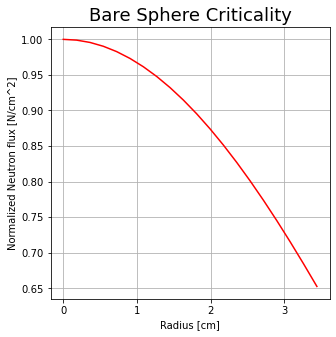

In [5]:
import pandas as pd

df = pd.read_csv('inputEigenProblem_out_x-data_0001.csv')
df2 = pd.read_csv('inputEigenProblem_out.csv')
unormal=df2["u-normalized"]
fig = plt.figure(figsize=(5,5))
plt.plot(df["x"],df["u_v"]/unormal[1],"r-")

u_values=df["u_v"]/unormal[1]
plt.grid()

plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

plt.title("Bare Sphere Criticality")
plt.show()



Multiplicity factor for FDM =  
 0.4152031425248163
Multiplicity factor for FEM =  
 0    0.415202
Name: eigen_values_real, dtype: float64


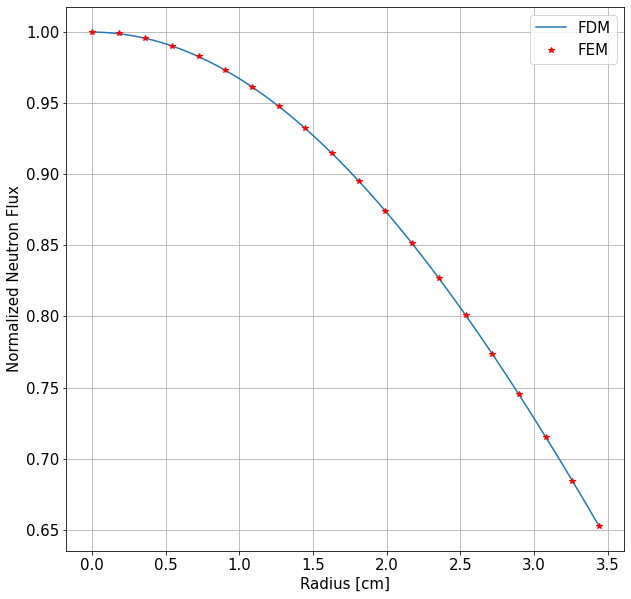

In [6]:
Nr= 75

rn=3.44
r0=0






h=(rn-r0)/(Nr-1)
r = np.arange(r0,rn + h,h)

A=np.zeros((Nr,Nr))
B=np.zeros(Nr)


A[0,0]=-2*D1/h**2
A[0,1]=2*D1/h**2


for i in range(1,Nr-1):
    A[i,i-1]=(1-(h/r[i]))*D1/h**2  
    A[i,i]=-2*D1/h**2
    A[i,i+1]=(1+(h/r[i]))*D1/h**2


A[-1,-1]=-(2*D1/h**2+1/h+1/(rn))
A[-1,-2]=(2)*D1/h**2

D, V = LA.eig(A)


eigen_value=D
eigen_vec=V[:,1]
c_star_vec=eigen_vec/LA.norm(eigen_vec[:][0])


eigen_values = np.flip(np.sort(abs(D)))

k_FDM=(v[0]*chi[0]*sigma_f[0])/(min(abs(D))+sigma_a[0]-sigma_12)


k_FEM=(v[0]*chi[0]*sigma_f[0])/(lam+sigma_a[0]-sigma_12)

print('Multiplicity factor for FDM =  \n',k_FDM)
print('Multiplicity factor for FEM =  \n',k_FEM)

DD = abs(c_star_vec)
DD /= DD.max()

plt.figure(figsize=(10,10))
plt.plot(r,DD,label="FDM")
plt.plot(df["x"],df["u_v"]/unormal[1],"r*",label="FEM")
plt.grid()
plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron Flux")
plt.legend()
plt.show()

#### [One-Group Energy Reflector Sphere](#toc)<a id="onegroupenergy"></a>

In [53]:
!rm inputEigenProblem_out_eigenvalue-data_0001*.csv
!./neutron__transport-opt -i inputEigenProblem_reflector.hit

rm: cannot remove 'inputEigenProblem_out_eigenvalue-data_0001*.csv': No such file or directory


Framework Information:
MOOSE Version:           git commit 1d1b703aef on 2021-08-22
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Mon May  9 09:04:06 2022
Executable Timestamp:    Mon May  9 08:50:44 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   11
  Elems:                   5
  Num Subdomains:          1

Nonlinear System:
  Num DOFs:                11
  Num Local DOFs:          11
  Variables:               "u_r" 
  Finite Element Types:    "LAGRANGE" 
  Approximation Orders:    "SECOND" 

Execution Information:
  Executioner:             Eigenvalue
  Solver Mode:             Preconditioned JFNK


Postprocessor Values:
+----------------+----------------+
| time 

In [54]:
import numpy as np
import pandas as pd
df = pd.read_csv('inputEigenProblem_reflector_out_eigenvalue-data_0001.csv')
lam =df["eigen_values_real"]


k=(v[0]*chi[0]*sigma_f[0])/(lam+sigma_a[0]-sigma_12)


print('Multiplicity factor for group-1 = ',k)



Multiplicity factor for group-1 =  0    0.499887
Name: eigen_values_real, dtype: float64


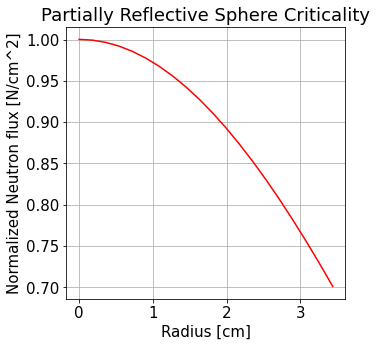

In [55]:
import pandas as pd

df = pd.read_csv('inputEigenProblem_reflector_out_x-data_0001.csv')
df2 = pd.read_csv('inputEigenProblem_reflector_out.csv')
unormal=df2["u-normalized"]
fig = plt.figure(figsize=(5,5))
plt.plot(df["x"],df["u_r"]/unormal[1],"r-")

u_values=df["u_r"]/unormal[1]
plt.grid()

plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron flux [N/cm^2]")
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 15}
plt.rc('font', **font)

plt.title("Partially Reflective Sphere Criticality")
plt.show()



Multiplicity factor for FDM =  
 0.3986963939765626
Multiplicity factor for FEM =  
 0    0.499887
Name: eigen_values_real, dtype: float64


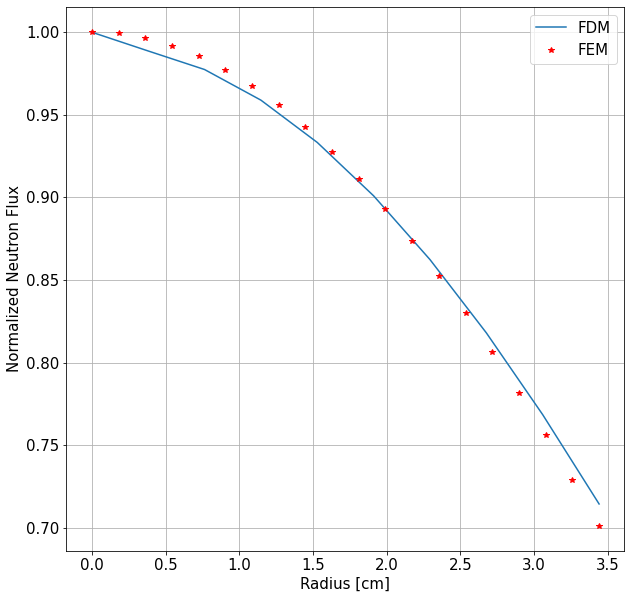

In [62]:
Nr= 10

rn=3.44
r0=0

alpha = 0.1




h=(rn-r0)/(Nr-1)
r = np.arange(r0,rn + h,h)

A=np.zeros((Nr,Nr))
B=np.zeros(Nr)


A[0,0]=-2*D1/h**2
A[0,1]=2*D1/h**2


for i in range(1,Nr-1):
    A[i,i-1]=(1-(h/r[i]))*D1/h**2  
    A[i,i]=-2*D1/h**2
    A[i,i+1]=(1+(h/r[i]))*D1/h**2


#A[-1,-1]=(-2*D1/h**2-1/h-1/(rn))
#A[-1,-2]=(2)*D1/h**2

A[-1,-1]=((1-alpha)/(1+alpha))*(-2*D1/h**2-1/h-1/(rn))
A[-1,-2]=(2)*D1/h**2
D, V = LA.eig(A)


eigen_value=D
eigen_vec=V[:,1]
c_star_vec=eigen_vec/LA.norm(eigen_vec[:][0])


eigen_values = np.flip(np.sort(abs(D)))

k_FDM=(v[0]*chi[0]*sigma_f[0])/(min(abs(D))+sigma_a[0]-sigma_12)


k_FEM=(v[0]*chi[0]*sigma_f[0])/(lam+sigma_a[0]-sigma_12)

print('Multiplicity factor for FDM =  \n',k_FDM)
print('Multiplicity factor for FEM =  \n',k_FEM)

DD = abs(c_star_vec)
DD /= DD.max()

plt.figure(figsize=(10,10))
plt.plot(r,DD,label="FDM")
plt.plot(df["x"],df["u_r"]/unormal[1],"r*",label="FEM")
plt.grid()
plt.xlabel("Radius [cm]")
plt.ylabel("Normalized Neutron Flux")
plt.legend()
plt.show()

In [11]:
book_params = False
openMC_xs = False

x_a = 0.0
x_interface = 3.44
x_b = 10.0

fdp_full = True

if book_params:
    diff_coeff_u1_c = 1.0
    diff_coeff_u1_m = 1.0

    fiss_u1_c = 0.057
    #fiss_u1_c = 30

    sigma_abs_u1_c = 0.001
    sigma_abs_u1_m = 0.001
    
else:

    diff_coeff_u1_c = 1.84
    diff_coeff_u1_m = 1.64

    fiss_u1_c = 0.174
    #fiss_u1_c = 30

    sigma_abs_u1_c = 0.0745
    sigma_abs_u1_m = 0.00534
    
if openMC_xs:
    diff_coeff_u1_c = 1.33
    diff_coeff_u2_c = 0.0292

    diff_coeff_u1_m = 7.25e-01
    diff_coeff_u2_m = 4.52e-01

    sigma_s12_c = 3.21e-07
    sigma_s12_m = 3.74e-04

    fiss_u1_c = 2.20e-01
    #fiss_u1_c = 30

    fiss_u2_c = 2.16e+01

    sigma_abs_u1_c = 7.61e-02
    sigma_abs_u2_c = 1.10e+01

    sigma_abs_u1_m = 1.47e-03
    sigma_abs_u2_m = 5.94e-04

order = variable_order = 'second'
flux_order = 'first'

diffFlux_family = 'monomial_vec'
diffFlux_r_family = 'monomial'

#robin_u_ref = 0.0
#robin_transfer_coeff = 10.0e+10

n_felem_core = 300
n_felem_reflector = 300

u1_initial = 100000

interfacial_transfer_coeff = 1000000000000000000.0
interfacial_adsorption_coeff = 0

u1_bc_left_neumann = 0
u2_bc_left_neumann = 0

u1_bc_right_robin_transfer_coeff = 10.0e+10

n_plot_pts_core = 2*n_felem_core + 1
n_plot_pts_reflector = 2*n_felem_reflector + 1

flux_ref = 0.0   #u_ref for robin boundary condition

inputFileName = "input_2Domain.hit"

In [12]:
def write_input_file_1d_coupled(pjfnk=False,filename='input.hit'):
    import pyhit
    import moosetree
    root = pyhit.load('')

    prblm = root.insert(-1,'Problem')
    prblm['type'] = 'FEProblem'
    prblm['coord_type'] = 'RSPHERICAL'

    mesh = root.insert(-1,'Mesh')
    
    omega1 = mesh.insert(-1,'omega1')
    omega1['type'] = 'GeneratedMeshGenerator'
    omega1['dim'] = 1
    omega1['xmin'] = x_a
    omega1['xmax'] = x_interface
    omega1['nx'] = n_felem_core
    omega1['boundary_name_prefix'] = 'omega_1'
    if order == 'second':
        omega1['elem_type'] = 'edge3'
    
    omega2 = mesh.insert(-1,'omega2')
    omega2['type'] = 'GeneratedMeshGenerator'
    omega2['dim'] = 1
    omega2['xmin'] = x_interface
    omega2['xmax'] = x_b
    omega2['nx'] = n_felem_reflector
    omega2['boundary_name_prefix'] = 'omega_2'
    if order == 'second':
        omega2['elem_type'] = 'edge3'

    omega = mesh.insert(-1,'omega')
    omega['type'] = 'StitchedMeshGenerator'
    omega['inputs'] = "'omega1 omega2'"
    omega['stitch_boundaries_pairs'] = "'omega_1_right omega_2_left'"
    omega['clear_stitched_boundary_ids'] = 'true'
    
    mod1 = mesh.insert(-1,'mod1')
    mod1['type'] = 'SubdomainBoundingBoxGenerator'
    mod1['input'] = 'omega'
    mod1['block_id'] = 1
    mod1['block_name'] = 'omega_1'
    mod1['bottom_left'] = str(x_a)+' 0 0'
    mod1['top_right'] = str(x_interface)+' 1 0'
    
    mod2 = mesh.insert(-1,'mod2')
    mod2['type'] = 'SubdomainBoundingBoxGenerator'
    mod2['input'] = 'mod1'
    mod2['block_id'] = 2
    mod2['block_name'] = 'omega_2'
    mod2['bottom_left'] = str(x_interface)+' 0 0'
    mod2['top_right'] = str(x_b)+' 1 0'
    
    mod3 = mesh.insert(-1,'mod3')
    mod3['type'] = 'SideSetsBetweenSubdomainsGenerator'
    mod3['input'] = 'mod2'
    mod3['primary_block'] = 'omega_1'
    mod3['paired_block'] = 'omega_2' 
    mod3['new_boundary'] = 'interface_12'
    
    mod4 = mesh.insert(-1,'mod4')
    mod4['type'] = 'SideSetsAroundSubdomainGenerator'
    mod4['input'] = 'mod3'
    mod4['block'] = 'omega_1'
    mod4['normal'] = '-1 0 0'
    mod4['new_boundary'] = 'omega_1_left'
    
    mod5 = mesh.insert(-1,'mod5')
    mod5['type'] = 'SideSetsAroundSubdomainGenerator'
    mod5['input'] = 'mod4'
    mod5['block'] = 'omega_2'
    mod5['normal'] = '1 0 0'
    mod5['new_boundary'] = 'omega_2_right'
    
    vars = root.insert(-1,'Variables')
    
    u1_c = vars.insert(-1,'u1_c')
    u1_c['block'] = 'omega_1'
    u1_c['order'] = order
    u1_c['family'] = 'lagrange'
    u1_c['initial_condition'] = u1_initial
    
    u1_m = vars.insert(-1,'u1_m')
    u1_m['block'] = 'omega_2'
    u1_m['order'] = order
    u1_m['family'] = 'lagrange'
    u1_m['initial_condition'] = u1_initial
    
    aux_vars = root.insert(-1,'AuxVariables')
    
    diffFlux_u1_c = aux_vars.insert(-1,'diffFlux_u1_c')
    diffFlux_u1_c['block'] = 'omega_1'
    diffFlux_u1_c['order'] = flux_order
    diffFlux_u1_c['family'] = diffFlux_family

    diffFlux_u1_m = aux_vars.insert(-1,'diffFlux_u1_m')
    diffFlux_u1_m['block'] = 'omega_2'
    diffFlux_u1_m['order'] = flux_order
    diffFlux_u1_m['family'] = diffFlux_family
    
    diffFlux_u1_c_r = aux_vars.insert(-1,'diffFlux_u1_c_r')
    diffFlux_u1_c_r['block'] = 'omega_1'
    diffFlux_u1_c_r['order'] = flux_order
    diffFlux_u1_c_r['family'] = diffFlux_r_family

    diffFlux_u1_m_r = aux_vars.insert(-1,'diffFlux_u1_m_r')
    diffFlux_u1_m_r['block'] = 'omega_2'
    diffFlux_u1_m_r['order'] = flux_order
    diffFlux_u1_m_r['family'] = diffFlux_r_family

    kernels = root.insert(-1,'Kernels')
    
    diffusion_term_u1_c = kernels.insert(-1,'diffusion_term_u1_c')
    diffusion_term_u1_c['type'] = 'DiffusionTerm'
    diffusion_term_u1_c['block'] = 'omega_1'
    diffusion_term_u1_c['variable'] = 'u1_c'
    diffusion_term_u1_c['diffCoeff'] = diff_coeff_u1_c
    
    diffusion_term_u1_m = kernels.insert(-1,'diffusion_term_u1_m')
    diffusion_term_u1_m['type'] = 'DiffusionTerm'
    diffusion_term_u1_m['block'] = 'omega_2'
    diffusion_term_u1_m['variable'] = 'u1_m'
    diffusion_term_u1_m['diffCoeff'] = diff_coeff_u1_m
    
    fission_source_u1_c = kernels.insert(-1,'fission_source_u1_c')
    fission_source_u1_c['type'] = 'FissionSource'
    fission_source_u1_c['block'] = 'omega_1'
    fission_source_u1_c['variable'] = 'u1_c'
    fission_source_u1_c['Sigma_nu'] = fiss_u1_c
    
    abs_u1_c = kernels.insert(-1,'abs_u1_c')
    abs_u1_c['type'] = 'SourceTermG1'
    abs_u1_c['block'] = 'omega_1'
    abs_u1_c['variable'] = 'u1_c'
    abs_u1_c['sigma_sa'] = -sigma_abs_u1_c
    
    abs_u1_m = kernels.insert(-1,'abs_u1_m')
    abs_u1_m['type'] = 'SourceTermG1'
    abs_u1_m['block'] = 'omega_2'
    abs_u1_m['variable'] = 'u1_m'
    abs_u1_m['sigma_sa'] = -sigma_abs_u1_m
    
    interf_kernels = root.insert(-1,'InterfaceKernels')
    
    scalar_flux_continuity_u1 = interf_kernels.insert(-1,'scalar_flux_continuity_u1')
    scalar_flux_continuity_u1['type'] = 'InterfaceDiffusion'
    scalar_flux_continuity_u1['variable'] = 'u1_c'
    scalar_flux_continuity_u1['neighbor_var'] = 'u1_m'
    scalar_flux_continuity_u1['boundary'] = 'interface_12'
    scalar_flux_continuity_u1['D'] = diff_coeff_u1_c
    scalar_flux_continuity_u1['D_neighbor'] = diff_coeff_u1_m
    
    scalar_flux_jump_u1 = interf_kernels.insert(-1,'scalar_flux_jump_u1')
    scalar_flux_jump_u1['type'] = 'InterfacePartition'
    scalar_flux_jump_u1['variable'] = 'u1_c'
    scalar_flux_jump_u1['neighbor_var'] = 'u1_m'
    scalar_flux_jump_u1['boundary'] = 'interface_12'
    scalar_flux_jump_u1['kCoeff'] = 1
    
    aux_kernels = root.insert(-1,'AuxKernels')
    
    diffusion_flux_u1_c = aux_kernels.insert(-1,'diffusion_flux_u1_c')
    diffusion_flux_u1_c['type'] = 'HeatFlux'
    diffusion_flux_u1_c['block'] = 'omega_1'
    diffusion_flux_u1_c['field'] = 'u1_c'
    diffusion_flux_u1_c['thCondCoeff'] = diff_coeff_u1_c
    diffusion_flux_u1_c['variable'] = 'diffFlux_u1_c'
    diffusion_flux_u1_c['execute_on'] = 'timestep_end'
    
    diffusion_flux_u1_m = aux_kernels.insert(-1,'diffusion_flux_u1_m')
    diffusion_flux_u1_m['type'] = 'HeatFlux'
    diffusion_flux_u1_m['block'] = 'omega_2'
    diffusion_flux_u1_m['field'] = 'u1_m'
    diffusion_flux_u1_m['thCondCoeff'] = diff_coeff_u1_m
    diffusion_flux_u1_m['variable'] = 'diffFlux_u1_m'
    diffusion_flux_u1_m['execute_on'] = 'timestep_end'
  
    diffusion_flux_u1_c_r = aux_kernels.insert(-1,'diffusion_flux_u1_c_r')
    diffusion_flux_u1_c_r['type'] = 'VectorVariableComponentAux'
    diffusion_flux_u1_c_r['block'] = 'omega_1'
    diffusion_flux_u1_c_r['vector_variable'] = 'diffFlux_u1_c'
    diffusion_flux_u1_c_r['component'] = "x"
    diffusion_flux_u1_c_r['variable'] = 'diffFlux_u1_c_r'
    diffusion_flux_u1_c_r['execute_on'] = 'timestep_end'

    diffusion_flux_u1_m_r = aux_kernels.insert(-1,'diffusion_flux_u1_m_r')
    diffusion_flux_u1_m_r['type'] = 'VectorVariableComponentAux'
    diffusion_flux_u1_m_r['block'] = 'omega_2'
    diffusion_flux_u1_m_r['vector_variable'] = 'diffFlux_u1_m'
    diffusion_flux_u1_m_r['component'] = "x"
    diffusion_flux_u1_m_r['variable'] = 'diffFlux_u1_m_r'
    diffusion_flux_u1_m_r['execute_on'] = 'timestep_end'
    
    
    bcs = root.insert(-1,'BCs')
    
    entry_u1 = bcs.insert(-1,'entry_u1')
    entry_u1['type'] = 'NeumannBC'
    entry_u1['variable'] = 'u1_c'
    entry_u1['boundary'] = 'omega_1_left'
    entry_u1['value'] = u1_bc_left_neumann 
    
    exit_u1 = bcs.insert(-1,'exit_u1')
    exit_u1['type'] = 'VacuumBC'
    exit_u1['variable'] = 'u1_m'
    exit_u1['boundary'] = 'omega_2_right'
    
    functions = root.insert(-1,'Functions')
    
    ref_flux_func = functions.insert(-1, 'refFluxFunc')
    ref_flux_func['type'] = 'ParsedFunction'
    ref_flux_func['value'] = 'flux_ref'
    ref_flux_func['vars'] = 'flux_ref'
    ref_flux_func['vals'] = str(flux_ref)
    
    if pjfnk:
        exe = root.insert(-1,'Executioner')
        exe['type'] = 'Steady'
        exe['solve_type']  = 'PJFNK'
        exe['petsc_options_iname']  = '-pc_type -pc_hypre_type'
        exe['petsc_options_value']  = 'hypre boomeramg'
        exe['l_max_its']  = 20
        exe['l_tol']  = 1e-5
        exe['nl_max_its']  = 15
        exe['nl_rel_tol']  = 1e-8
        exe['nl_abs_tol']  = 1e-8
    elif fdp_full:
        pre = root.insert(-1, 'Preconditioning')
        pre['active'] = 'fdp-newt-full'
        
        fdp = pre.insert(-1, 'fdp-newt-full')
        fdp['type'] = 'FDP'
        fdp['full'] = 'true'
        fdp['solve_type'] = 'NEWTON'
        fdp['petsc_options_iname'] = ""'-pc_type -mat_fd_coloring_err -mat_fd_type'""
        fdp['petsc_options_value'] = ""'lu  1e-8          ds'""
        
        exe = root.insert(-1,'Executioner')
        exe['type'] = 'Steady'

    vp = root.insert(-1,'VectorPostprocessors')
    
    omega_1 = vp.insert(-1,'omega_1')
    omega_1['type'] = 'LineValueSampler'
    omega_1['execute_on'] = 'timestep_end final'
    omega_1['variable'] = 'u1_c diffFlux_u1_c_r'  
    omega_1['start_point'] = str(x_a)+' 0 0'
    omega_1['end_point'] = str(x_interface*0.999)+' 0 0'
    omega_1['num_points'] = n_plot_pts_core
    omega_1['sort_by'] = 'id'
    
    omega_2 = vp.insert(-1,'omega_2')
    omega_2['type'] = 'LineValueSampler'
    omega_2['execute_on'] = 'timestep_end final'
    omega_2['variable'] = 'u1_m diffFlux_u1_m_r'   
    omega_2['start_point'] = str(x_interface*1.001)+' 0 0'
    omega_2['end_point'] = str(x_b)+' 0 0'
    omega_2['num_points'] = n_plot_pts_reflector
    omega_2['sort_by'] = 'id'  

    out = root.insert(-1,'Outputs')
    out['console'] = 'true'
    csv = out.insert(-1,'csv')
    csv['type'] = 'CSV'
    csv['file_base'] = 'output'
    csv['execute_on'] = 'final'
    
    debug = root.insert(-1,'Debug')
    debug['show_var_residual_norms'] = 'true'

    pyhit.write(filename, root)

In [13]:
write_input_file_1d_coupled(pjfnk=True,filename=inputFileName)
!cat input_2Domain.hit

[Problem]
  type = FEProblem
  coord_type = RSPHERICAL
[]
[Mesh]
  [omega1]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = 0.0
    xmax = 3.44
    nx = 300
    boundary_name_prefix = omega_1
    elem_type = edge3
  []
  [omega2]
    type = GeneratedMeshGenerator
    dim = 1
    xmin = 3.44
    xmax = 10.0
    nx = 300
    boundary_name_prefix = omega_2
    elem_type = edge3
  []
  [omega]
    type = StitchedMeshGenerator
    inputs = 'omega1 omega2'
    stitch_boundaries_pairs = 'omega_1_right omega_2_left'
    clear_stitched_boundary_ids = true
  []
  [mod1]
    type = SubdomainBoundingBoxGenerator
    input = omega
    block_id = 1
    block_name = omega_1
    bottom_left = '0.0 0 0'
    top_right = '3.44 1 0'
  []
  [mod2]
    type = SubdomainBoundingBoxGenerator
    input = mod1
    block_id = 2
    block_name = omega_2
    bottom_left = '3.44 0 0'
    top_right = '10.0 1 0'
  []
  [mod3]
    type = SideSetsBetweenSubdomainsGenerator
    input = mod2
    primary_block = o

In [14]:
!./neutron__transport-opt -i input_2Domain.hit


In ReplicatedMesh::stitch_meshes:
This mesh has 1 nodes on boundary 1.
Other mesh has 1 nodes on boundary 0.
Minimum edge length on both surfaces is 0.0114667.
In ReplicatedMesh::stitch_meshes:
Found 1 matching nodes.

Elem::centroid() has been deprecated. Replace with either Elem::vertex_average() to maintain existing behavior, or the more expensive Elem::true_centroid() in cases where the true 'geometric' centroid is required.

Framework Information:
MOOSE Version:           git commit 1d1b703aef on 2021-08-22
LibMesh Version:         
PETSc Version:           3.15.1
SLEPc Version:           3.15.1
Current Time:            Mon May  9 08:51:47 2022
Executable Timestamp:    Mon May  9 08:50:44 2022

Parallelism:
  Num Processors:          1
  Num Threads:             1

Mesh: 
  Parallel Type:           replicated
  Mesh Dimension:          1
  Spatial Dimension:       1
  Nodes:                   1201
  Elems:                   600
  Num Subdomains:          2

Nonlinear System:
  Nu

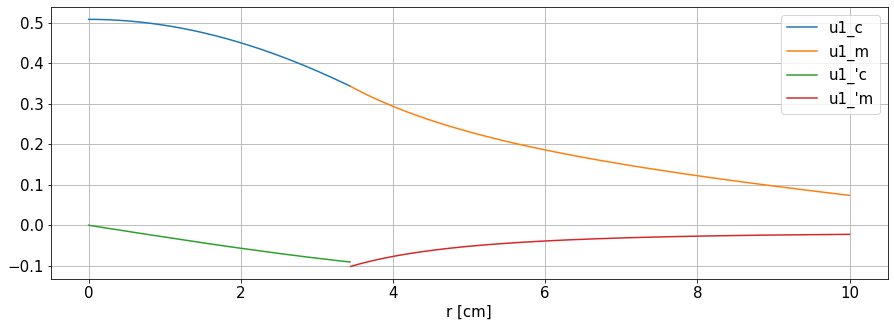

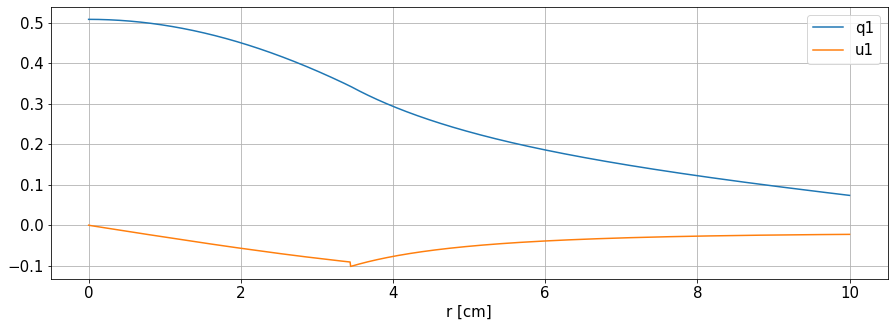

In [15]:
'''Show FEM Solution'''

import pandas as pd
df1 = pd.read_csv('output_omega_1_0002.csv')
df2 = pd.read_csv('output_omega_2_0002.csv')
df_list = [df1,df2]
save_name = "2Domain.png"

#display(df1)
#display(df2)

x_list = [df1["x"],df2["x"]]
y_list = [[df1["diffFlux_u1_c_r"],df1["u1_c"]],
          [df2["diffFlux_u1_m_r"],df2["u1_m"]]]
labels = ["u1'","u1"]
domain = ["core","reflector"]


plt.figure(figsize=(15,5))
for i in range(1):
    for j,domain in enumerate(["c","m"]):
        field = "u"+str(i+1)+"_"
        plt.plot(df_list[j]["x"],df_list[j][field+domain],label=field+domain)
        
    for j,domain in enumerate(["c","m"]):
        field = "u"+str(i+1)+"_"
        plt.plot(df_list[j]["x"],df_list[j]["diffFlux_u"+str(i+1)+"_"+domain+"_r"],label=field+"'"+domain)
        
plt.legend()
plt.grid()
plt.xlabel("r [cm]")
plt.show()


x_total = pd.concat([df1["x"], df2["x"]])
u1 = pd.concat([df1["u1_c"] ,df2["u1_m"]])
u1_prime = pd.concat([df1["diffFlux_u1_c_r"] , df2["diffFlux_u1_m_r"]])

data_list = [u1,u1_prime]
labels = ["q1","u1"]

plt.figure(figsize=(15,5))
for i,data in enumerate(data_list):
    plt.plot(x_total,data,label=labels[i])

plt.legend()
plt.grid()
plt.xlabel("r [cm]")
plt.savefig("1Group.png",dpi=300)
plt.show()